In [ ]:
!pip install keras-tuner

     |████████████████████████████████| 133 kB 5.2 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import pickle
import cv2
import os

In [ ]:
from PIL import Image
import numpy as np
import tarfile
import matplotlib.pyplot as plt

In [ ]:
# unpickling the annotation files
train_annotation = pickle.load(open('/content/drive/MyDrive/Colab_Notebooks/Vehicle_Reidentification/train_annotation.pkl', 'rb'))
test_annotation = pickle.load(open('/content/drive/MyDrive/Colab_Notebooks/Vehicle_Reidentification/test_annotation.pkl', 'rb'))
test_dev_annotation = pickle.load(open('/content/drive/MyDrive/Colab_Notebooks/Vehicle_Reidentification/test_dev_annotation.pkl', 'rb'))

In [ ]:
file = tarfile.open('/content/drive/MyDrive/Colab_Notebooks/Vehicle_Reidentification/images_train.tar')
file.extractall('/content/vehicle_images')
file.close()

In [ ]:
file = tarfile.open('/content/drive/MyDrive/Colab_Notebooks/Vehicle_Reidentification/images_test.tar')
file.extractall('/content/vehicle_images')
file.close()

In [ ]:
file = tarfile.open('/content/drive/MyDrive/Colab_Notebooks/Vehicle_Reidentification/images_dev.tar')
file.extractall('/content/vehicle_images')
file.close()

In [ ]:
import os
import shutil

src = '/content/vehicle_images/images_train/'
dest = '/content/vehicle_images/'
allfiles = os.listdir(src)
for f in allfiles:
    shutil.move(src + f, dest + f)

In [ ]:
src = '/content/vehicle_images/images_test/'
dest = '/content/vehicle_images/'
allfiles = os.listdir(src)
for f in allfiles:
    shutil.move(src + f, dest + f)

In [ ]:
src = '/content/vehicle_images/images_dev/'
dest = '/content/vehicle_images/'
allfiles = os.listdir(src)
for f in allfiles:
    shutil.move(src + f, dest + f)

In [ ]:
train_annotation.keys(), test_annotation.keys(), test_dev_annotation.keys()

(dict_keys(['train_im_names', 'wheel_label', 'type_label', 'color_label', 'luggage_label', 'd_part_label', 'sky_label', 'bumper_label']),
 dict_keys(['query_order', 'wheel_label', 'type_label', 'gallery_order', 'color_label', 'luggage_label', 'd_part_label', 'test_im_names', 'bumper_label', 'sky_label']),
 dict_keys(['query_order', 'wheel_label', 'dev_im_names', 'type_label', 'color_label', 'luggage_label', 'd_part_label', 'sky_label', 'bumper_label', 'gallery_order']))

In [ ]:
annotations = {}
for ind in train_annotation['type_label']:
    img_name = train_annotation['train_im_names'][ind]
    annotations[img_name] = train_annotation['type_label'][ind]

In [ ]:
annotations.update(test_annotation['type_label'])
annotations.update(test_dev_annotation['type_label'])

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
Counter(annotations.values())

Counter({0: 61227, 1: 5551, 2: 42675, 3: 2834, 4: 15398, 5: 9567, 6: 158})

In [ ]:
strategy = {0:1000, 1:1000, 2:1000, 3:1000, 4:1000, 5:1000, 6:0}
undersample = RandomUnderSampler(sampling_strategy = strategy)
X1, y1 = np.array(list(annotations.keys())), np.array(list(annotations.values()))
X1 = X1.reshape(-1,1)
y1 = y1.reshape(-1,1)
annot_name1, annot_label1 = undersample.fit_resample(X1, y1)
Counter(annot_label1)

Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000})

In [ ]:
img_data, labels = [], []
path ='/content/vehicle_images/'
for file in annot_name1:
  img_arr = cv2.imread(os.path.join(path, file[0]))[...,::-1] #convert BGR to RGB format
  resized_arr = cv2.resize(img_arr, (224, 224))
  img_data.append(resized_arr)

In [ ]:
for i in range(6000):
  labels.append(annot_label1[i])

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img_data, labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [ ]:
for i in range(len(X_train)):
  X_train[i]=cv2.normalize(X_train[i], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
for i in range(len(X_val)):
  X_val[i]=cv2.normalize(X_val[i], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
for i in range(len(X_test)):
  X_test[i]=cv2.normalize(X_test[i], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX) 

In [ ]:
X_train = np.array(X_train).astype('float32')
X_val = np.array(X_val).astype('float32')
X_test = np.array(X_test).astype('float32')
y_train = np.array(y_train).reshape((-1,1))
y_val = np.array(y_val).reshape((-1,1))
y_test = np.array(y_test).reshape((-1,1))

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((3840, 224, 224, 3), (960, 224, 224, 3), (1200, 224, 224, 3))

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf

In [ ]:
from tensorflow.keras import Model 
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential

In [ ]:
from keras_tuner.protos.keras_tuner_pb2 import Choice
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(224,224,3)
    ),

    keras.layers.MaxPool2D(
        pool_size=hp.Choice('max_pool_1', values = [3,5])
    ),
    
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),

    keras.layers.MaxPool2D(
        pool_size=hp.Choice('max_pool_2', values = [3,5])
    ),
    
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.Dense(10, activation='softmax')
  ])
  
  model.compile(optimizer=tf.keras.optimizers.SGD(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [ ]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


In [ ]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=3,directory='output',project_name="VRAI")

In [ ]:
tuner_search.search(X_train,y_train,epochs=3,validation_data=(X_val, y_val), batch_size=5)

Trial 3 Complete [00h 20m 15s]
val_accuracy: 0.4166666567325592

Best val_accuracy So Far: 0.4166666567325592
Total elapsed time: 01h 12m 02s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner_search.results_summary()

Results summary
Results in output/VRAI
Showing 10 best trials
Trial summary
Hyperparameters:
conv_1_filter: 48
conv_1_kernel: 5
max_pool_1: 3
conv_2_filter: 48
conv_2_kernel: 5
max_pool_2: 3
dense_1_units: 112
learning_rate: 0.001
Score: 0.4166666567325592
Trial summary
Hyperparameters:
conv_1_filter: 80
conv_1_kernel: 5
max_pool_1: 3
conv_2_filter: 48
conv_2_kernel: 5
max_pool_2: 3
dense_1_units: 64
learning_rate: 0.001
Score: 0.4072916805744171
Trial summary
Hyperparameters:
conv_1_filter: 128
conv_1_kernel: 5
max_pool_1: 5
conv_2_filter: 32
conv_2_kernel: 3
max_pool_2: 5
dense_1_units: 32
learning_rate: 0.001
Score: 0.3177083432674408


In [ ]:
model=tuner_search.get_best_models(num_models=1)[0]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 48)      3648      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 48)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 48)        57648     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 48)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 25392)             0         
                                                                 
 dense (Dense)               (None, 112)               2

In [ ]:
history = model.fit(X_train, y_train, epochs=23, validation_data=(X_val, y_val), initial_epoch=3, batch_size=5)

Epoch 4/23
768/768 [==============================] - 433s 564ms/step - loss: 1.3027 - accuracy: 0.4982 - val_loss: 1.3597 - val_accuracy: 0.4740
Epoch 5/23
768/768 [==============================] - 397s 516ms/step - loss: 1.2127 - accuracy: 0.5388 - val_loss: 1.3755 - val_accuracy: 0.4500
Epoch 6/23
768/768 [==============================] - 396s 516ms/step - loss: 1.1138 - accuracy: 0.5867 - val_loss: 1.3180 - val_accuracy: 0.4760
Epoch 7/23
768/768 [==============================] - 395s 515ms/step - loss: 1.0128 - accuracy: 0.6341 - val_loss: 1.3475 - val_accuracy: 0.4896
Epoch 8/23
768/768 [==============================] - 394s 513ms/step - loss: 0.9126 - accuracy: 0.6828 - val_loss: 1.3929 - val_accuracy: 0.4917
Epoch 9/23
768/768 [==============================] - 393s 512ms/step - loss: 0.7902 - accuracy: 0.7276 - val_loss: 1.5064 - val_accuracy: 0.4625
Epoch 10/23
768/768 [==============================] - 392s 510ms/step - loss: 0.6733 - accuracy: 0.7703 - val_loss: 1.5303 

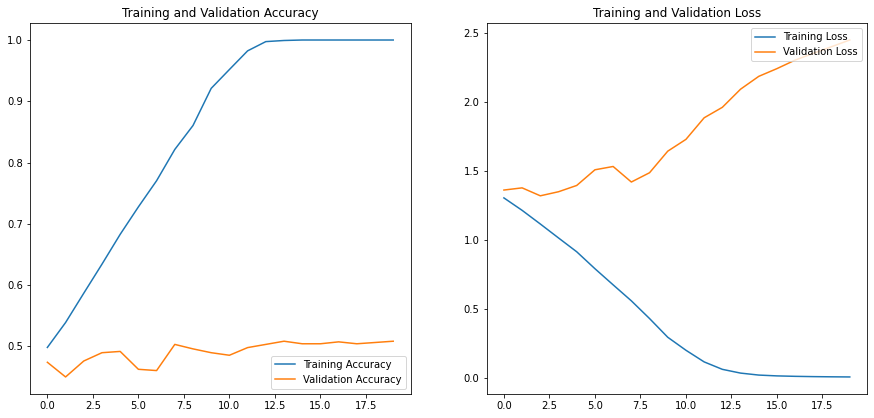

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report: \n", classification_report(y_test, y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.46      0.42      0.44       200
           1       0.47      0.48      0.48       200
           2       0.40      0.42      0.41       200
           3       0.76      0.74      0.75       200
           4       0.46      0.47      0.46       200
           5       0.58      0.57      0.57       200

    accuracy                           0.52      1200
   macro avg       0.52      0.52      0.52      1200
weighted avg       0.52      0.52      0.52      1200



In [ ]:
import seaborn as sns

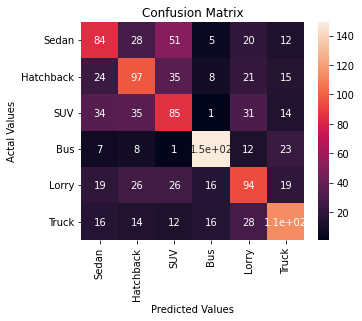

In [ ]:
cm = confusion_matrix(y_test, y_pred_classes)
cm_df = pd.DataFrame(cm,
                     index = ['Sedan', 'Hatchback', 'SUV', 'Bus', 'Lorry', 'Truck',], 
                     columns = ['Sedan', 'Hatchback', 'SUV', 'Bus', 'Lorry', 'Truck',])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()